In [1]:
import numpy as np

import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from xhistogram.xarray import histogram
import dask.dataframe as dd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import mitequinox.utils as ut
from mitequinox.plot import *
import mitequinox.parcels as pa
from xmitgcm import llcreader

from fsspec.implementations.local import LocalFileSystem

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.5456960.datarmor0/parcels-502090/libparcels_random_1adb9af5-ba7a-4a9f-bb3b-768c06299f40.so


In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster() #processes=7, cores=7
w = cluster.scale(jobs=4)
#
client = Client(cluster)




In [3]:
client

Client Scheduler: tcp://10.148.1.40:36738 Dashboard: http://10.148.1.40:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [4]:
def read_Ediag(V,diags):
    ds = xr.merge([ut.load_diagnostic(d+"_"+v).rename({v:d+"_"+v}) 
               for v in V for d in diags])

    grid = xr.open_zarr('/home1/datawork/xyu/grid/mit_grid.zarr')
    ds = xr.merge([ds,grid])
    #ds = ds#.isel(i = slice(0,None,4), j = slice(0,None,4), i_g = slice(0,None,4), j_g = slice(0,None,4))
    ds['lon'] = 0*ds.face+ds.XC
    ds['lat'] = 0*ds.face+ds.YC
    ds = ds.compute()
    # Rotation velocity field
    for diag in diags:
        ds['zonal_velocity_'+diag] =  ds[diag+'_SSU'].rename({'i_g': 'i'})*ds.CS - ds[diag+'_SSV'].rename({'j_g': 'j'})*ds.SN
        ds['meridional_velocity_'+diag] =  ds[diag+'_SSU'].rename({'i_g': 'i'})*ds.SN + ds[diag+'_SSV'].rename({'j_g': 'j'})*ds.CS

        ds['lon'] = 0*ds.face+ds.XC
        ds['lat'] = 0*ds.face+ds.YC
 #   ds = llcreader.faces_dataset_to_latlon(ds)
    return ds

In [57]:
def localize_Eulerian(bbox,ds,col):
    ds_sub = ds[col].where(np.logical_and(ds.lat<=bbox[3],ds.lat>=bbox[2]),drop=True).persist()
    ds_lon = ds['lon'].where(np.logical_and(ds.lat<=bbox[3],ds.lat>=bbox[2]),drop=True).persist()
    ds_lat = ds['lat'].where(np.logical_and(ds.lat<=bbox[3],ds.lat>=bbox[2]),drop=True).persist()
    ds_bis = xr.Dataset({'lon':ds_lon,col:ds_sub,'lat':ds_lat})
    ds_sub = ds_bis.where(np.logical_and(ds_bis.lon<=bbox[1],ds_bis.lon>=bbox[0]),drop=True).persist()
    #ds_sub = ds_sub.to_dataframe()
    #lon_E = ds_sub.lon[0,:,0]
    #lat_E = ds_sub.lat[0,0,:]
    #ds_E = xr.DataArray(ds_sub.isel(face=0)['zonal_velocity_mean'].values,dims=['lon','lat'],coords={'lon':lon_E.values,'lat':lat_E.values})
    return ds_sub

In [37]:
def localize_Lagrangian(bbox,df):
    df_sub = df[np.logical_and(df.lat<bbox[3],df.lat>bbox[2]
                                               )].persist()

    df_sub = df_sub[np.logical_and(df_sub.lon<bbox[1],df_sub.lon>bbox[0]
                                          )].persist()
    return df_sub

In [106]:
def binned_mean(df,dl):
    """Average dataframe over bins width dl
    
    Parameters 
    df : dataframe with at least longitude, latitude and field to bin in columns
    dl : bin width
    
    Returns
    df_mean : dataset with averaged fields
    """
    lonmin,lonmax = df.lon.values.min(),df.lon.values.max()
    latmin,latmax = df.lat.values.min(),df.lat.values.max()
    lon = np.arange(lonmin,lonmax, dl)
    lat = np.arange(latmin, latmax, dl)
    df['lon_cut'] = pd.cut(df['lon'], lon)
    df['lat_cut'] = pd.cut(df['lat'], lat)
    df_mean = df.groupby(['lon_cut','lat_cut']).mean()
    df_mean = pa.add_geodata(df_mean)
    df_mean = (df_mean
     #     .drop(columns=['Coordinates'])
          .set_index(['lon', 'lat'])
         .to_xarray()
        )
    df_count = df.groupby(['lon_cut','lat_cut']).count()
    df_count = pa.add_geodata(df_count)
    df_count = (df_count
     #     .drop(columns=['Coordinates'])
          .set_index(['lon', 'lat'])
         .to_xarray()
        )
    df_mean['count'] = df_count.zonal_velocity_mean
    return df_mean

In [8]:
def binned_site(bbox,df,dl,V):
    df_sub = df[np.logical_and(df.lat<bbox[3],df.lat>bbox[2]
                                               )].persist()

    df_sub = df[np.logical_and(df.lon<bbox[1],df.lon>bbox[0]
                                          )].persist()
    lon = np.arange(bbox[0],bbox[1], dl)
    lat = np.arange(bbox[-2], bbox[-1], dl)
    df_sub['lon'] = (df_sub['lon']+180)%360 - 180
    df_sub['lon_cut'] = df_sub['lon'].map_partitions(pd.cut, lon)
    df_sub['lat_cut'] = df_sub['lat'].map_partitions(pd.cut, lat)
    df_sub = df_sub.persist()
    uv_sub = df_sub.groupby(['lon_cut','lat_cut']).mean().compute()
    return uv_sub

In [9]:
ds = ut.load_data(['SSU','SSV'])

In [10]:
ds

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, time: 8785)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    niter    (time) int64 dask.array<chunksize=(200,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2011-11-15 2011-11-15T01:00:00 ... 2012-11-15
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
Data variables:
    SSU      (time, face, j, i_g) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    SSV      (time, face, j_g, i) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>

In [38]:
# Lagrangian data
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'

p = pa.parcels_output(root_dir+run_name, parquets=['time_mean'])
df = p.df['time_mean']

df = pa.degs2ms(df) #Convert in m/s 

df = df.persist()

In [39]:
df = df.drop(columns=['temperature','sea_level','salinity','SST_interp','SSS_interp','Eta_interp'])
df = df.rename(columns={'SSU_interp':'zonal_velocity_mean','SSV_interp':'meridional_velocity_mean'})

In [40]:
df= df.persist()

In [12]:
# Eulerian data
V = ["SSU","SSV"]#["SSU", "SSV"]
D = ["mean"]#, "prime_mean","prime_mean_sq"]
ds = read_Ediag(V,D)

In [13]:
bbox = [-128, -123, 33, 38] # small bbox
dl = 1.

In [41]:
df_sub = localize_Lagrangian(bbox,df)

In [42]:
df_sub = df_sub.compute()

In [26]:
ds_sub = localize_Eulerian(bbox,ds,'zonal_velocity_mean')

In [29]:
#ds_sub = ds_sub.drop(['face','CS','SN','XC','YC','rA'])#.plot.scatter()
ds_sub = ds_sub.drop(['Depth'])

In [33]:
df_E = ds_sub.isel(face=0).to_dataframe()

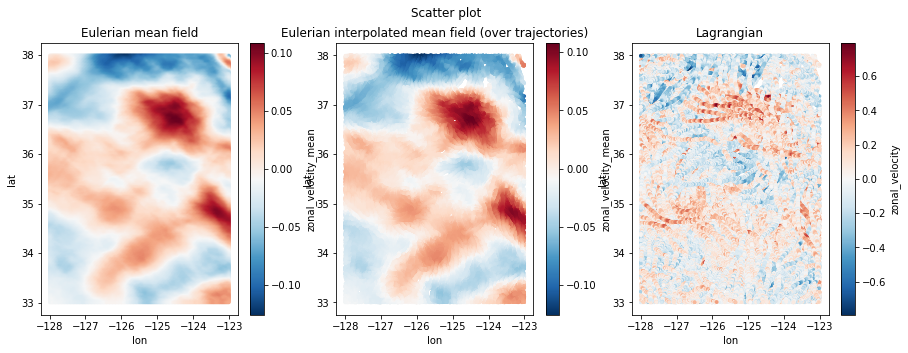

In [48]:
fig, axs = plt.subplots(1,3,figsize=(15,5))
df_E.plot.scatter(x='lon',y='lat',c='zonal_velocity_mean',cmap='RdBu_r',ax=axs[0],s=6)
df_sub.plot.scatter(x='lon',y='lat',c='zonal_velocity_mean',cmap='RdBu_r',ax=axs[1],s=6)
df_sub.plot.scatter(x='lon',y='lat',c='zonal_velocity',cmap='RdBu_r',ax=axs[2],s=6)
fig.suptitle('Scatter plot')
for title,ax in zip(['Eulerian mean field','Eulerian interpolated mean field (over trajectories)','Lagrangian'],axs):
    ax.set_title(title)

In [58]:
ds_sub_V = localize_Eulerian(bbox,ds,'meridional_velocity_mean')

In [59]:
ds_sub_V = ds_sub_V.drop(['face','CS','SN','XC','YC','rA','Depth'])
ds_sub_V

<xarray.Dataset>
Dimensions:                   (face: 1, i: 320, j: 240)
Coordinates:
  * j                         (j) int64 0 1 2 3 4 5 ... 234 235 236 237 238 239
  * i                         (i) int64 2898 2899 2900 2901 ... 3215 3216 3217
Dimensions without coordinates: face
Data variables:
    lon                       (face, j, i) float64 -128.0 -128.0 ... -123.0
    meridional_velocity_mean  (face, j, i) float32 -0.08 -0.07922 ... -0.09239
    lat                       (face, j, i) float64 37.99 37.98 ... 33.02 33.01

In [60]:
df_EV = ds_sub_V.isel(face=0).to_dataframe()

In [63]:
df_E = df_E.merge(df_EV)

In [74]:
df_E

,lon,zonal_velocity_mean,lat,meridional_velocity_mean
0,-127.989586,-0.000739,37.994099,-0.080003
1,-127.968750,-0.000010,37.994099,-0.081511
2,-127.947914,0.001029,37.994099,-0.082241
3,-127.927086,0.001954,37.994099,-0.081219
4,-127.906250,0.002786,37.994099,-0.079250
...,...,...,...,...
76795,-123.093750,0.039737,33.005322,-0.092674
76796,-123.072914,0.038550,33.005322,-0.092572
76797,-123.052086,0.037448,33.005322,-0.092213
76798,-123.031250,0.036609,33.005322,-0.092231


In [72]:
'zonal_velocity_mean'.split('_m')[0]

'zonal_velocity'

Text(0.5, 0.98, 'Scatter plot')

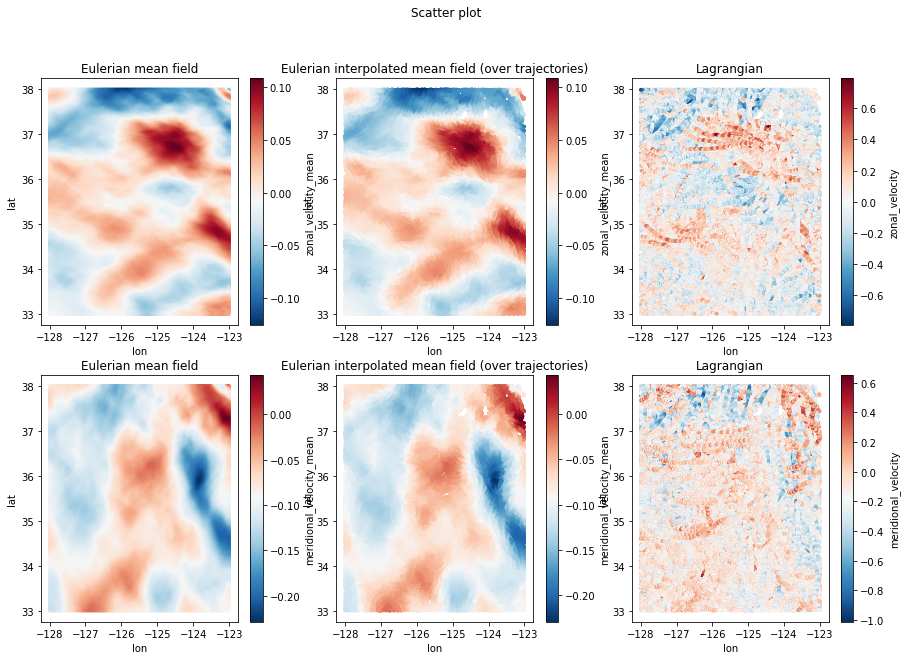

In [76]:
fig, axs = plt.subplots(2,3,figsize=(15,10))
for i,V in enumerate(['zonal_velocity_mean','meridional_velocity_mean']):
    df_E.plot.scatter(x='lon',y='lat',c=V,cmap='RdBu_r',ax=axs[i,0],s=6)
    df_sub.plot.scatter(x='lon',y='lat',c=V,cmap='RdBu_r',ax=axs[i,1],s=6)
    df_sub.plot.scatter(x='lon',y='lat',c=V.split('_m')[0],cmap='RdBu_r',ax=axs[i,2],s=6)

    for title,ax in zip(['Eulerian mean field','Eulerian interpolated mean field (over trajectories)','Lagrangian'],axs[i,:]):
        ax.set_title(title)

fig.suptitle('Scatter plot')

In [107]:
dfE_1dl = binned_mean(df_E,dl)
dfL_1dl = binned_mean(df_sub,dl)

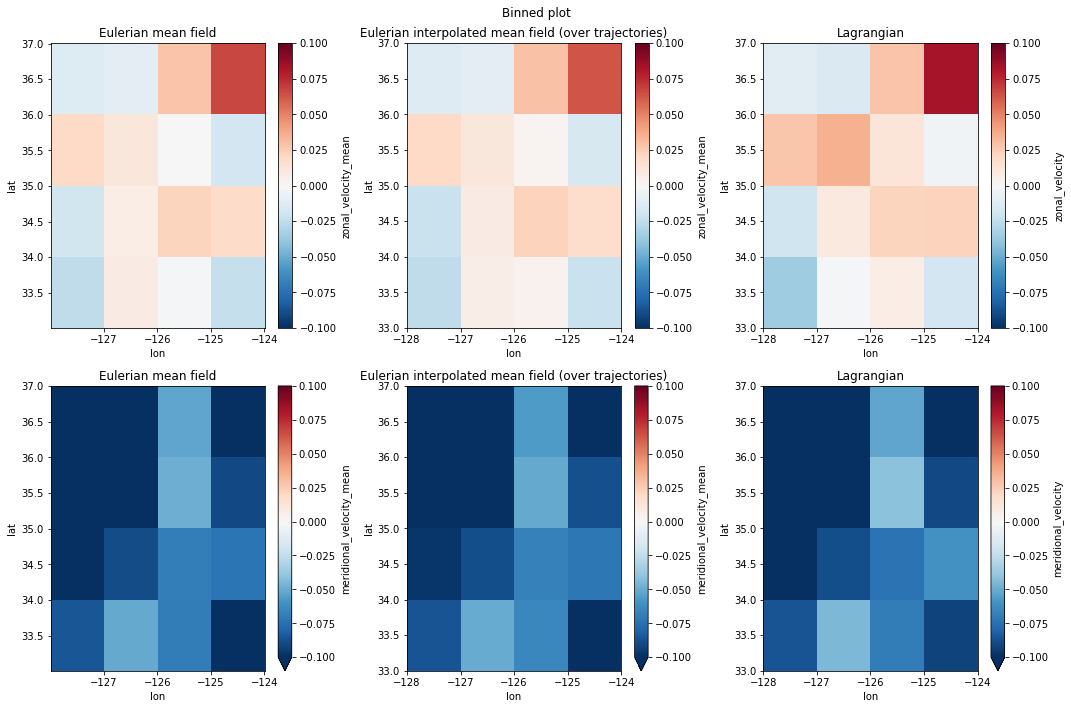

In [114]:
vmax = 0.1
fig, axs = plt.subplots(2,3,figsize=(15,10))
for i,V in enumerate(['zonal_velocity_mean','meridional_velocity_mean']):
    dfE_1dl[V].plot(x='lon',y='lat',cmap='RdBu_r',ax=axs[i,0],vmax=vmax)
    dfL_1dl[V].plot(x='lon',y='lat',cmap='RdBu_r',ax=axs[i,1],vmax=vmax)
    dfL_1dl[V.split('_m')[0]].plot(x='lon',y='lat',cmap='RdBu_r',ax=axs[i,2],vmax=vmax)

    for title,ax in zip(['Eulerian mean field','Eulerian interpolated mean field (over trajectories)','Lagrangian'],axs[i,:]):
        ax.set_title(title)

fig.suptitle('Binned plot')
fig.tight_layout()


In [116]:
dfE_1dl = dfE_1dl.assign_coords({'lon':dfL_1dl.lon.values,'lat':dfL_1dl.lat.values})

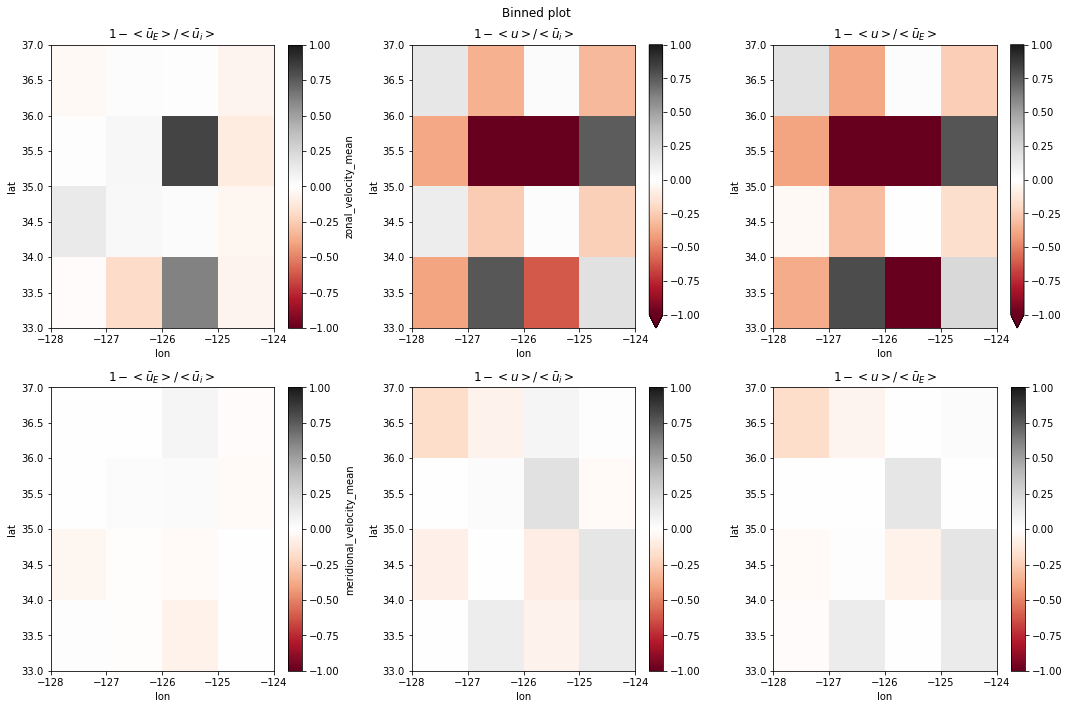

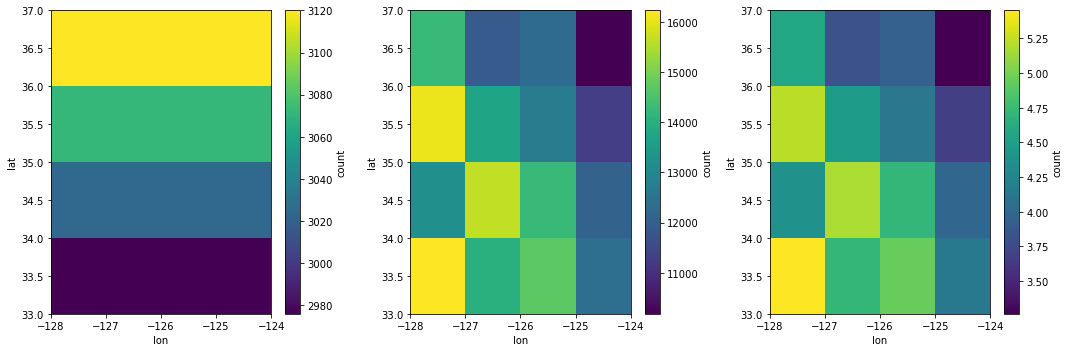

In [119]:
cmap='RdGy'
fig, axs = plt.subplots(2,3,figsize=(15,10))
for i,V in enumerate(['zonal_velocity_mean','meridional_velocity_mean']):
    (1-np.abs(dfE_1dl[V]/dfL_1dl[V])).plot(x='lon',y='lat',cmap=cmap,ax=axs[i,0],vmax=1)
    (1-np.abs(dfL_1dl[V.split('_m')[0]]/dfL_1dl[V])).plot(x='lon',y='lat',cmap=cmap,ax=axs[i,1],vmax=1)
    (1-np.abs(dfL_1dl[V.split('_m')[0]]/dfE_1dl[V])).plot(x='lon',y='lat',cmap=cmap,ax=axs[i,2],vmax=1)

    for title,ax in zip([r'$1-<\bar u_E>/<\bar u_i>$',r'$1-<u>/<\bar u_i>$',r'$1-<u>/<\bar u_E>$'],axs[i,:]):
        ax.set_title(title)

fig.suptitle('Binned plot')
fig.tight_layout()
fig,ax = plt.subplots(1,3,figsize=(15,5))
dfE_1dl['count'].plot(y='lat',ax=ax[0])
dfL_1dl['count'].plot(y='lat',ax=ax[1])
(dfL_1dl['count']/dfE_1dl['count']).plot(y='lat',ax=ax[2])
fig.tight_layout()

#### Notes (figure interpretation) : 
Left column : 

1) values smaller than 0 <=> Eulerian values higher than Eulerian interpolated values
2) 0<values<1 <=> Eulerian values smaller than Eulerian interpolated values
3) values=0 <=> Eulerian values equal Eulerian interpolated values

Middle column : 

1) values smaller than 0 <=> Lagrangian values higher than Eulerian interpolated values
2) 0<values<1 <=> Lagrangian values smaller than Eulerian interpolated values
3) values=0 <=> Lagrangian values equal Eulerian interpolated values

Right column : 

1) values smaller than 0 <=> Lagrangian values higher than Eulerian values
2) 0<values<1 <=> Lagrangian values smaller than Eulerian values
3) values=0 <=> Lagrangian values equal Eulerian values

In [27]:
ds_sub.name = 'zonal_velocity_mean'
ds_sub_V.name = 'meridional_velocity_mean'

In [28]:
_ds_sub = xr.merge([ds_sub,ds_sub_V])

In [34]:
_ds_sub

<xarray.Dataset>
Dimensions:                   (lat: 320, lon: 240)
Coordinates:
  * lon                       (lon) float64 -128.0 -128.0 ... -123.0 -123.0
  * lat                       (lat) float64 37.99 37.98 37.96 ... 33.02 33.01
Data variables:
    zonal_velocity_mean       (lon, lat) float32 -0.0007393 0.001687 ... 0.03561
    meridional_velocity_mean  (lon, lat) float32 -0.08 -0.07922 ... -0.09239

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


<AxesSubplot:xlabel='lon', ylabel='lat'>

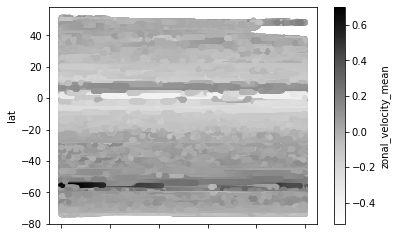

In [57]:
df_sub.plot.scatter(x='lon',y='lat',c='zonal_velocity_mean')

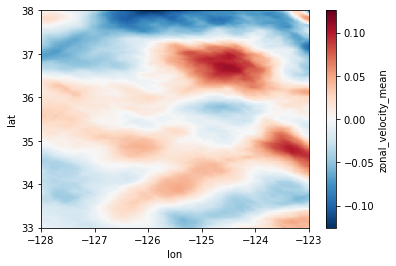

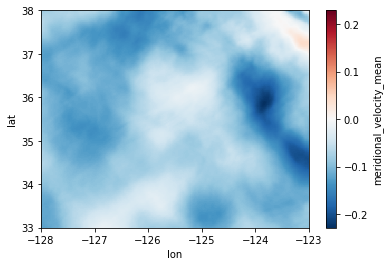

In [37]:
_ds_sub['zonal_velocity_mean'].plot(y='lat')
plt.figure()
_ds_sub['meridional_velocity_mean'].plot(y='lat')

In [104]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
